# Guidelines
---

> This notebook is a template of what could be explored. You can follow it or explore and experiment additional things.

> Use the notebook to add your comments, figures... You can remove and reorganize it as you wish. The goal is for you to make a nice report. The important points are to: 
- understand what you will write
- explain the experimental results
- the code should be clean and well documented
- when copy many times the same code, take the time to create a function instead. 

# Autoencoders
---

> An autoencoder (**AE**) is a special type of neural network that is trained to copy its input to its output. For an image of handwritten digits, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes this latent representation go recover the original image. Of course, in the middle you have a compression of the information, and the task should not be trivial. 

> An autoencoder learns to compress the data while minimizing the reconstruction error. This is an example of unsupervised learning. 
Autoencoder can be used to learn representation (the by product of the encoder), and to detect anomalies.

> An autoencoder consists in two blocks: 
- the encoder projects the input in a latent space of "reduced" dimension (in comparison with the input). 
- the decoder maps some latent representation back in the input space. 

> Basically, if you consider an input $\mathbf{x}$ : 
$$\mathbf{z} = encoder(\mathbf{x})$$
$$\mathbf{\tilde{x}} = decoder(\mathbf{z})$$

> The goal is to train the AE. The goal is to minimize the reconstruction error. This error can be defined as the mean square error  : 
$$\min||\mathbf{\tilde{x}}-\mathbf{x}||^2$$ 

> For this lab session, you can work with the Fashion MNIST dataset, or the MNIST dataset. It is maybe better to use MNIST (I prefer). 


> **Representation Learning and semi-supervised training:** Assume we have many images without annotation in class. We can train an AE on this dataset. Then if a small subset of these images are annotated, we can train a classifier by reusing the encoder part of the AE. The encoder can learn (unsupervised) to represent data from many images, and the (supervised) classifier can leverage the small set of annotated data with the pre-trained encoder. 

> **Anomalie detection:** Assume we have a large dataset. For example, the dataset contains only images of faces. Then we want to detect anomalies: images that do not represent faces like we have in our dataset. The AE is a simple and efficient tool to achieve anomalie detection. The reconstruction error should be high if it is an anomalie and low otherwise. 

> Before experimenting these kind of applications, let us build and explore AEs.

# Initialization of session
---

Imports and datasets. You need the dataset. 

In [ ]:
#Connecting to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
import _pickle as cPickle
import  gzip
import numpy as np

import math

import matplotlib
%matplotlib inline
%config InlineBackend.figure_formats=['retina']
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
th.manual_seed(1) # Set the seed 
import pickle

from time import time

filename='/content/drive/MyDrive/Colab Notebooks/mnist.pkl.gz' # mnist dataset

T = 50000 # Number of images for training
V = 10000 # Number of images for validation
fp = gzip.open(filename,'rb')
u = pickle._Unpickler( fp )
u.encoding = 'latin1'
train, valid, test  = u.load() 
allXtrain , allYtrain = train
print(allXtrain.shape)

# Below we ensure that the values of pixels are between 0 and 1.  
maxv   = allXtrain[0].max()
Xtrain = allXtrain[:T]/maxv
Ytrain = allYtrain[:T]
Xvalid = valid[0][:V]/maxv
Yvalid = valid[1][:V]
print(Xtrain.shape[0] , "Training images" )
print(Xvalid.shape[0] , "CV images" )

# Converting in tensor
Xtrain = th.from_numpy(Xtrain)
Ytrain = th.from_numpy(Ytrain)
Xvalid = th.from_numpy(Xvalid)
Yvalid = th.from_numpy(Yvalid)

(50000, 784)
50000 Training images
10000 CV images


## Auxiliary functions

In [ ]:
def plot_grid(n, m, X, figsz=None, img_dim=(28,28), title = ''):
  fig, axes = plt.subplots(n, m, figsize = figsz)

  index = 0 # counter

  # Random images
  img_idx = np.arange(X.shape[0]) # Generate the indices 
  np.random.shuffle(img_idx) # Random order of indices
  shuffled_X = X[img_idx]

  for i in range(n):
    for j in range(m):
      im = shuffled_X[index]
      axes[i,j].imshow(im.reshape(img_dim) , matplotlib.pyplot.cm.gray)
      axes[i,j].axis('off')
      index += 1

  fig.suptitle(title)

  plt.show()

In [ ]:
def plot_comparison(n, m, X, Y, figsz=None, title = ''):
  fig, axes = plt.subplots(n, 2*m, figsize = figsz)
  
  index = 0 # counter

  # Random images
  img_idx = np.arange(X.shape[0]) # Generate the indices 
  np.random.shuffle(img_idx) # Random order of indices
  shuffled_X = X[img_idx]
  shuffled_Y = Y[img_idx]

  for i in range(n):
    for j in range(m):
      im = shuffled_X[index] # AE output image
      axes[i,j].imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray)
      axes[i,j].axis('off')

      im = shuffled_Y[index] # Input image
      axes[i,j+m].imshow(im.reshape(28,28) , matplotlib.pyplot.cm.gray)
      axes[i,j+m].axis('off')

      index += 1
  
  fig.suptitle(title)
 
  plt.show()

In [ ]:
def plot_encoder(encoded_data, labels, figsz=None):
  fig, ax = plt.subplots(figsize=figsz)
  x = encoded_data[:,0]
  y = encoded_data[:,1]

  for g in np.unique(labels):
    i = np.where(labels == g)
    ax.scatter(x[i], y[i], label=g, marker='.' )

  ax.axis('off')
  fig.suptitle('Encoder scatter plot')
  ax.legend()
  plt.show()

In [ ]:
# Transpose dataset
def transpose_dataset(X):
  X_transposed = np.empty((X.shape[0], X.shape[1]), dtype=np.float32)
  for i in range(X.shape[0]):
    img_t = th.transpose(X[i,:].reshape(28,28), 0, 1)
    X_transposed[i,:] = img_t.reshape(784)
  X_transposed = th.from_numpy(X_transposed) # converting to torch tensor
  return X_transposed

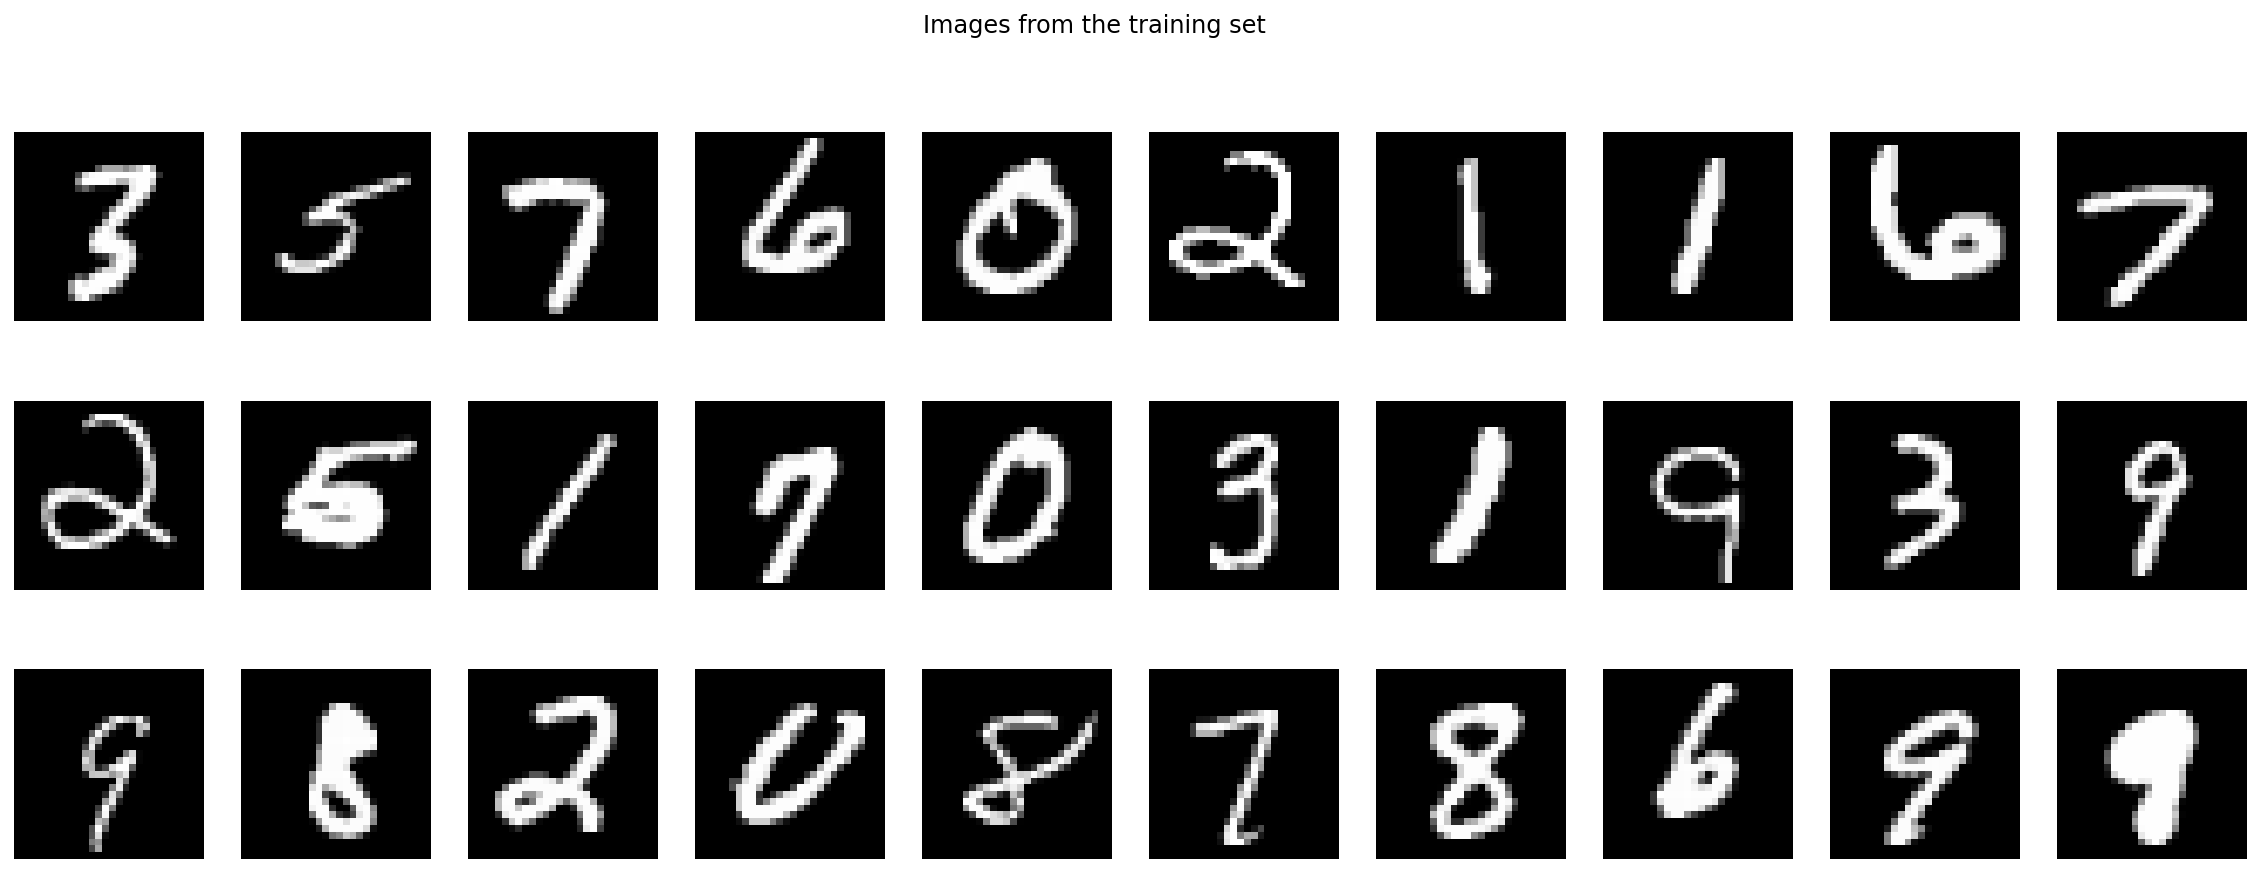

In [ ]:
# Exploring the examples on the dataset
plot_grid(3, 10, Xtrain.detach().numpy(), figsz=(20,7), title = 'Images from the training set')

# First try : Simple Auto-encoder
---

> The basic idea is to have a linear transformation followed by a non-linearity for both the encoder and decoder. 
For the output activation, we can use the sigmoid, since we know that the images are in greyscale, and the pixel values are between $0$ and $1$. 

> The only hyperparameter we have is the dimension of the latent space: $h < 784$.

> **TODO:** Write a class for the encoder and test it on some images as sanity-check. The idea is to define a class where we will have two
"blocks": the encoder and the decoder.  The encoder is a simple Linear layer followed by a non-linearity (like Relu for instance). The decoder is also a Linear Layer but followed by a sigmoid. The important hyper-parameter here is $h$. It should be a parameter given to the constructor.


In [ ]:
class SimpleAE(nn.Module):
    def __init__(self, D_in, D_h):
      super(SimpleAE, self).__init__()
      self.D_in = D_in # Input dimension
      self.D_h = D_h # Dimension of latent space
      self.D_out = D_in # Output dimension, which is equal to the input dimension

      # Encoder
      self.encoder = nn.Sequential(
          nn.Linear(self.D_in, self.D_h),
          nn.ReLU()
      )

      # Decoder
      self.decoder = nn.Sequential(
          nn.Linear(self.D_h, self.D_out),
          nn.Sigmoid()
      )

      # Loss function
      self.loss_fn = nn.MSELoss()

    def forward(self, x):
      """
        Foward propagation : encode => decode
      """
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

Input size: torch.Size([50000, 784])
Latent space size: torch.Size([50000, 2])
Decoded size: torch.Size([50000, 784])


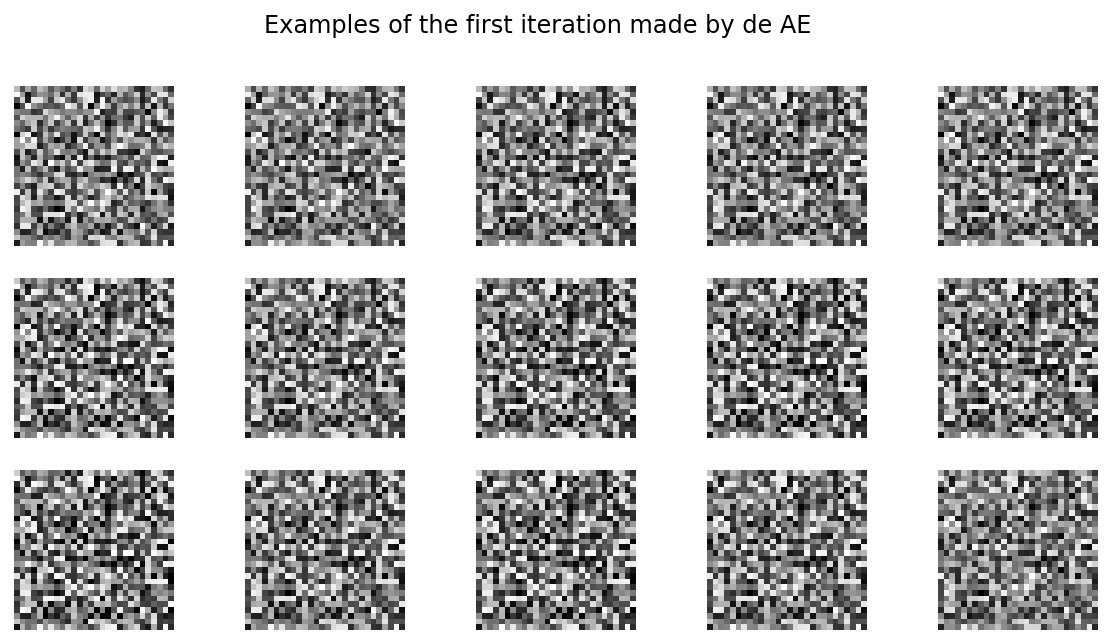

In [ ]:
# Creating the autoencoder object
AE = SimpleAE(784, 2)

# Observing the ouputs shapes
print('Input size:', Xtrain.shape)

latent_space = AE.encoder(Xtrain) # encoding
print('Latent space size:', latent_space.shape)

output = AE.decoder(latent_space) # decoding
print('Decoded size:', output.shape)

# Printing the image from the decoder (without optimization)
plot_grid(3, 5, output.detach().numpy(), figsz=(10,5), title = 'Examples of the first iteration made by de AE')

> **TODO:**
Write a function that train the autoencoder:
- for one model
- with some training data
- for some epochs
- with Adam and a tuneable learning rate.


> **TODO**:
- Then use this function to train the AE and look at some reconstructions to see the results. Start with a hidden dimension of $2$.
- With a hidden representation of dimension $h=2$. You can visualize the projections performed by the encoder of the images. Plot the hidden representation of each image according to the class. You can use the function scatter of matplotlib. You can also write a function that takes a model dataset (images and labels) and plots the projection (you will use it many times). 
* Don't forget to try different value of the learning rate **for all the experiments now and after !**  


In [ ]:
# Function developed based on TP1
# Autoencoder Trainer

def train(model, optimizer, loss_fn, Xtrain, Xvalid, epochs=30, minibatch=200, verbose=False):
  # The verbose allows you to skip printed information per epoch.
  # The function will only print the best accuracy on the validation
  # and plot the learning curves.

  ### Mini-batching and shuffle 
  Ntrain = Xtrain.shape[0]
  idx = np.arange(Ntrain) # Generate the indices 
  nbatch = int(Ntrain/minibatch) # Number of batches
  np.random.shuffle(idx) # Random order of indices 

  # Lists for learning curves
  loss_hist_train = list()
  loss_hist_cv = list()

  tac = time()
  for n in range(epochs):
    for bi in range(nbatch):
      ids = idx[bi*minibatch:(bi+1)*minibatch] # Get indices of minibatch bi
      images = Xtrain[ids]  # Get the images
      logprobs = model(images) # Inference
      loss=loss_fn(logprobs,images) # Compute the loss (compare output with input)
      optimizer.zero_grad()
      loss.backward() # Back Propagation
      optimizer.step() # Update the parameters
    
    # Train loss
    logprobs_train=model(Xtrain) # Inference of the epoch (train)
    loss_train=loss_fn(logprobs_train,Xtrain) # Compute the loss of the epoch (train)
    loss_hist_train.append(loss_train.item())

    # Validation
    with th.no_grad(): # No need to compute the gradient
      model.eval() # Activating the evaluation mode of the model
      logprobs_cv = model(Xvalid) # Inference of the epoch (cv)
      loss_cv=loss_fn(logprobs_cv,Xvalid) # Compute the loss of the epoch (cv)
      loss_hist_cv.append(loss_cv.item())
    
    model.train() # Returning to training mode
    tic = time()

    if verbose:
      print('Train loss:', loss_train.item(), '\tCV loss:', loss_cv.item())

    time_trainig = tic - tac

  return loss_hist_train, loss_hist_cv, time_trainig

lri: 0.1 => 23.23 s
lri: 0.01 => 22.41 s
lri: 0.001 => 23.21 s
lri: 0.0001 => 22.45 s


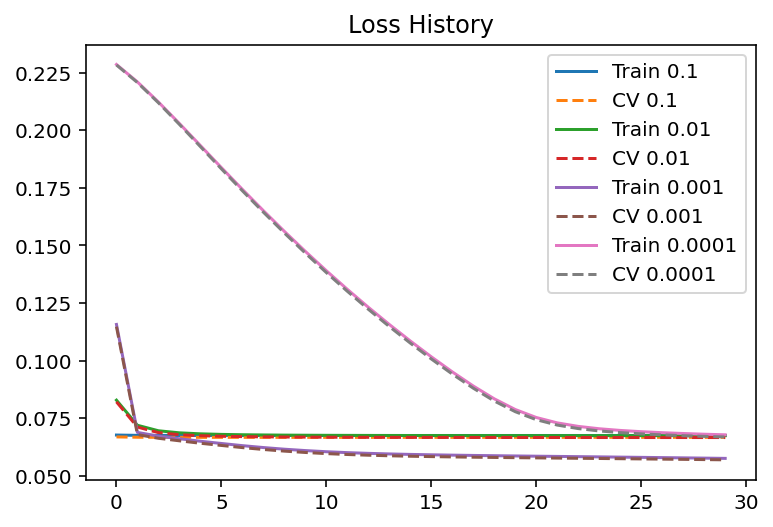

In [ ]:
# Model dimensions
D_in = 784
D_h = 2

# Optimizer and learning rate
for lri in [1e-1, 1e-2, 1e-3, 1e-4]:
  AE = SimpleAE(D_in, D_h)
  optimizer = th.optim.Adam(AE.parameters(),lr=lri)
  loss_hist_train, loss_hist_cv, time_trainig = train(AE, optimizer, AE.loss_fn, Xtrain, Xvalid, epochs=30)
  print('lri:', lri, '=> %.2f s' %time_trainig)

  plt.plot(loss_hist_train, label=('Train ' + str(lri))) # Loss plot (train)
  plt.plot(loss_hist_cv, label=('CV ' + str(lri)), linestyle='dashed') # Loss plot (cv)

plt.title('Loss History') # Title and axis title
plt.xlabel = 'Epoch'
plt.ylabel = 'Loss'
plt.legend()
plt.show()

---
> *After several experiments, the best hyperparameters founded were:*

> *For h=2: the best lr was 0.01 and Nepoch = 15*

> *For h=10: the best lr was 0.001 and Nepoch = 15*

> *For h=50: the best lr was 0.001 and Nepoch = 10*

> *For h=100: the best lr was 0.001 and Nepoch = 10*
---

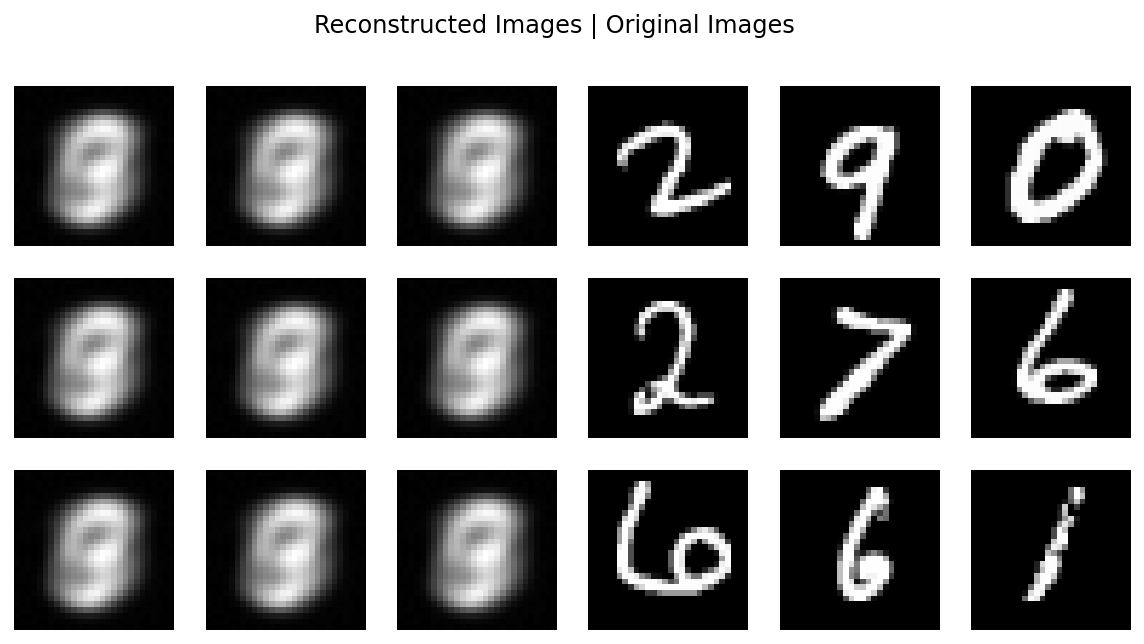

In [ ]:
# Model dimensions
D_in = 784
D_h = 2

# Model, optimizer and learning rate
AE = SimpleAE(D_in, D_h)
optimizer = th.optim.Adam(AE.parameters(), lr=0.01)

# Training the model
train(AE, optimizer, AE.loss_fn, Xtrain, Xvalid, epochs=15)

# AE output
decoded = AE.forward(Xtrain)

# Comparison plot
plot_comparison(3, 3, decoded.detach().numpy(), Xtrain.detach().numpy(), figsz=(10,5), title = 'Reconstructed Images | Original Images')

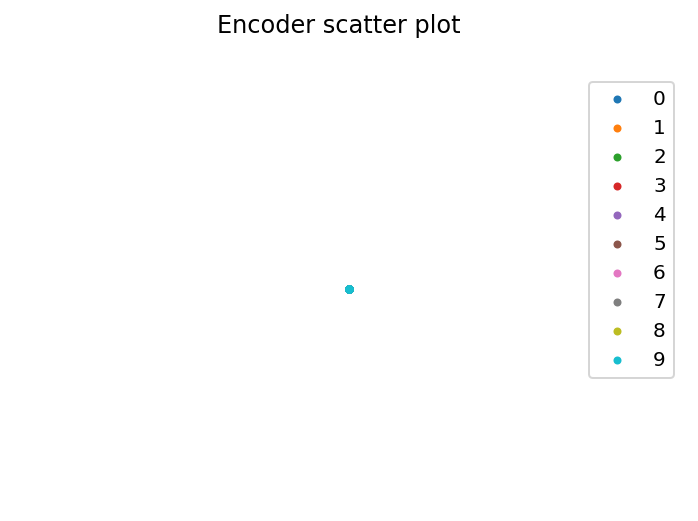

In [ ]:
# Scatter Plot
encoded_data = AE.encoder(Xtrain)
plot_encoder(encoded_data.detach().numpy(), Ytrain.detach().numpy())

---
> *It's surprisingly that all the encoded points goes to the same spot in the latent space. That's probably a consequence of the enormous compression of the information (dimension goes from 784 to 2).*

> *To try another approach, we could use a sigmoid activation for the encoder:*
---

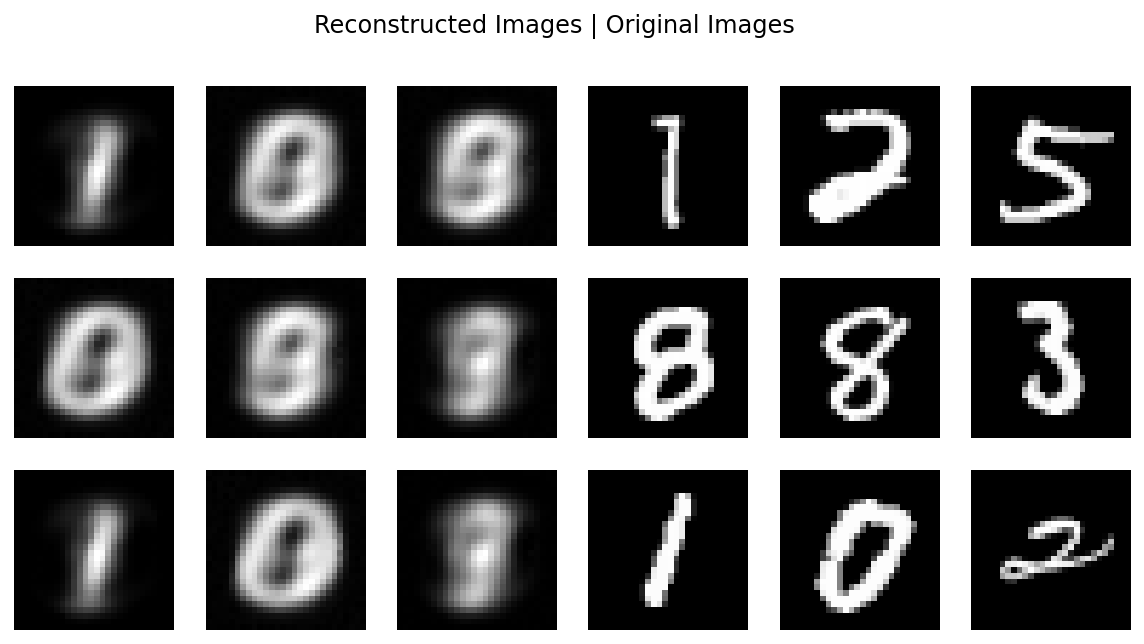

In [ ]:
# Model dimensions
D_in = 784
D_h = 2

# Changing the activation of the encoder
AE = SimpleAE(D_in, D_h)
AE.encoder = nn.Sequential(
    nn.Linear(D_in, D_h),
    nn.Sigmoid()
    )
optimizer = th.optim.Adam(AE.parameters(), lr=0.01)

# Training the model
train(AE, optimizer, AE.loss_fn, Xtrain, Xvalid, epochs=15)

# AE output
decoded = AE.forward(Xtrain)

# Comparison plot
plot_comparison(3, 3, decoded.detach().numpy(), Xtrain.detach().numpy(), figsz=(10,5), title = 'Reconstructed Images | Original Images')

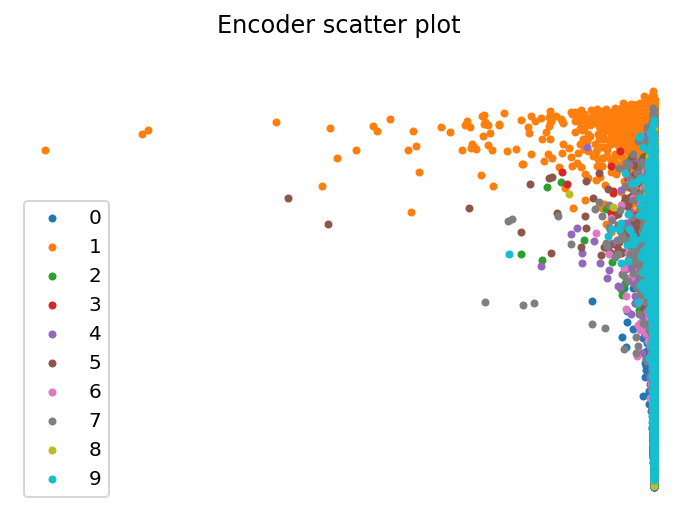

In [ ]:
# Scatter Plot
encoded_data = AE.encoder(Xtrain)
plot_encoder(encoded_data.detach().numpy(), Ytrain.detach().numpy())

---
> *We see that the reconstructed image looks like a mix of all numbers in the dataset, which is reasonable if we think that the network tries to compress a lot of information in a too little space*

> *Furthermore, using a sigmoid activation for encoding shows that the network don't compress all the information at the same point. However, we can't say that this is better than ReLU, because qualitatively all the reconstructed images looks the same*
---

## Increase the dimension of the latent representation
---

> **TODO:** Try different sizes (10 and 50). For a qualitative evaluation, you can take some randomly selected images

> And for these images plot (imshow) the original images and their reconstructions, syde by side. You can also evaluate your autoencoder with the reconstruction error measured on the validation set. 

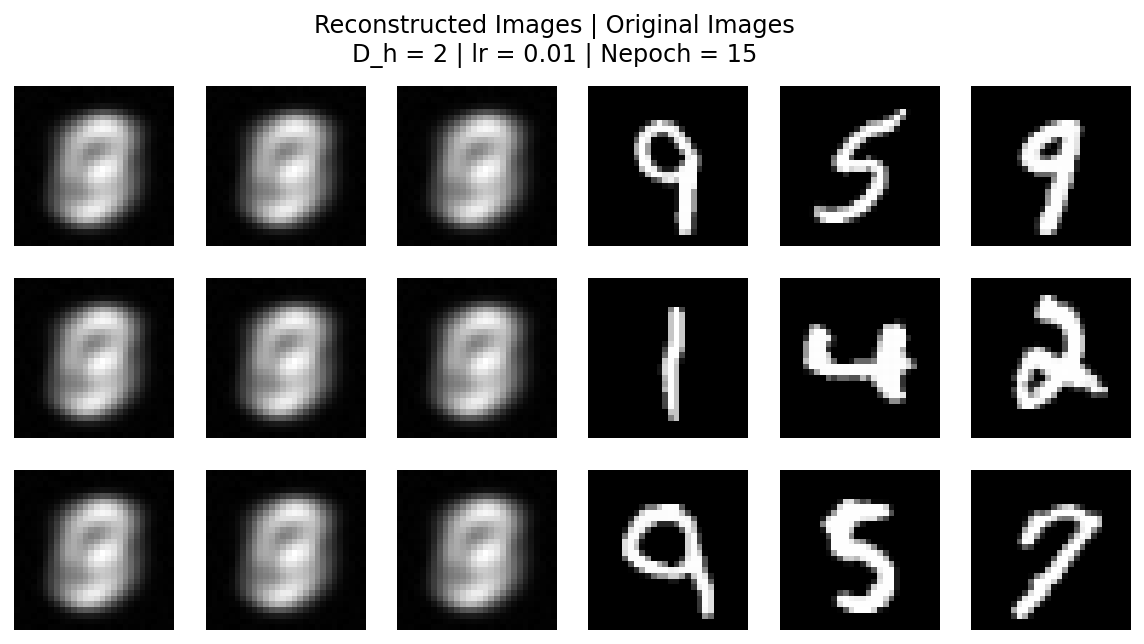

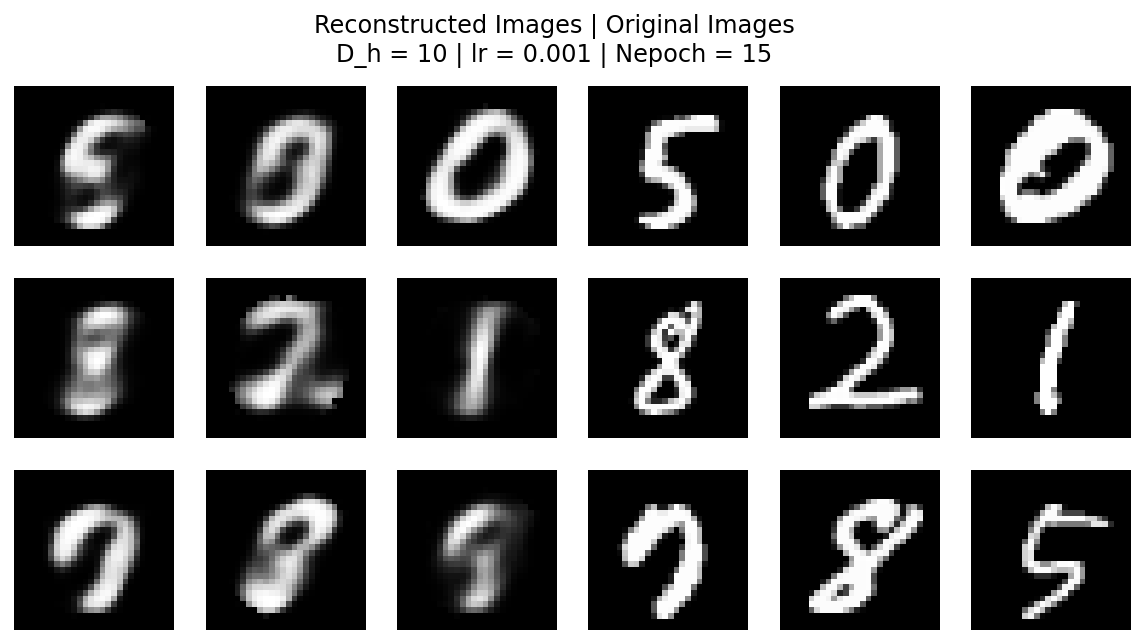

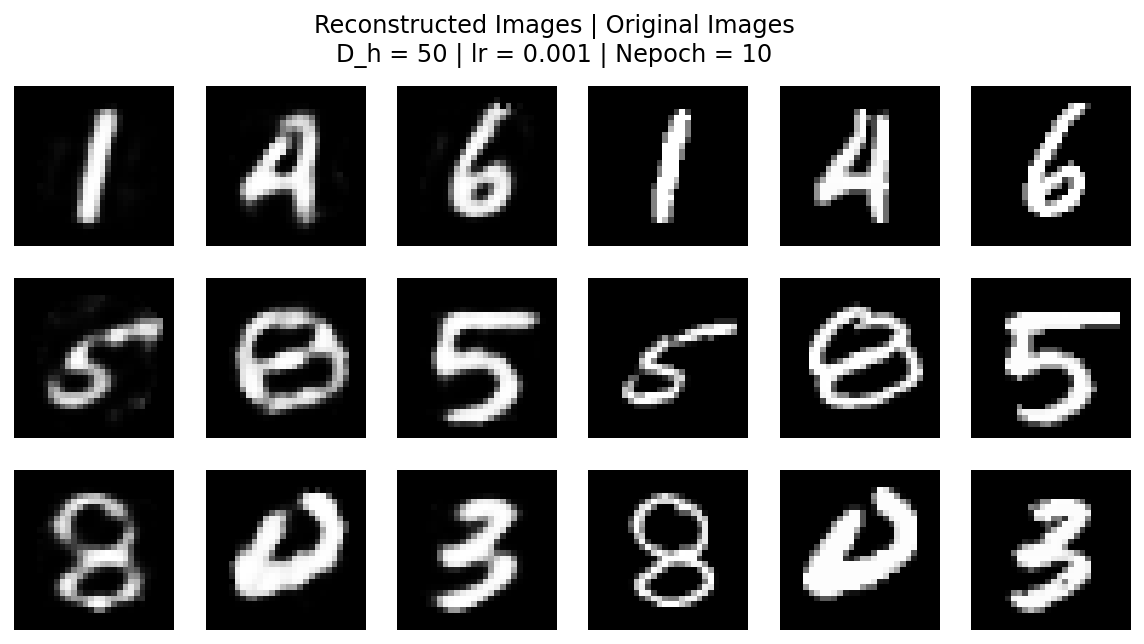

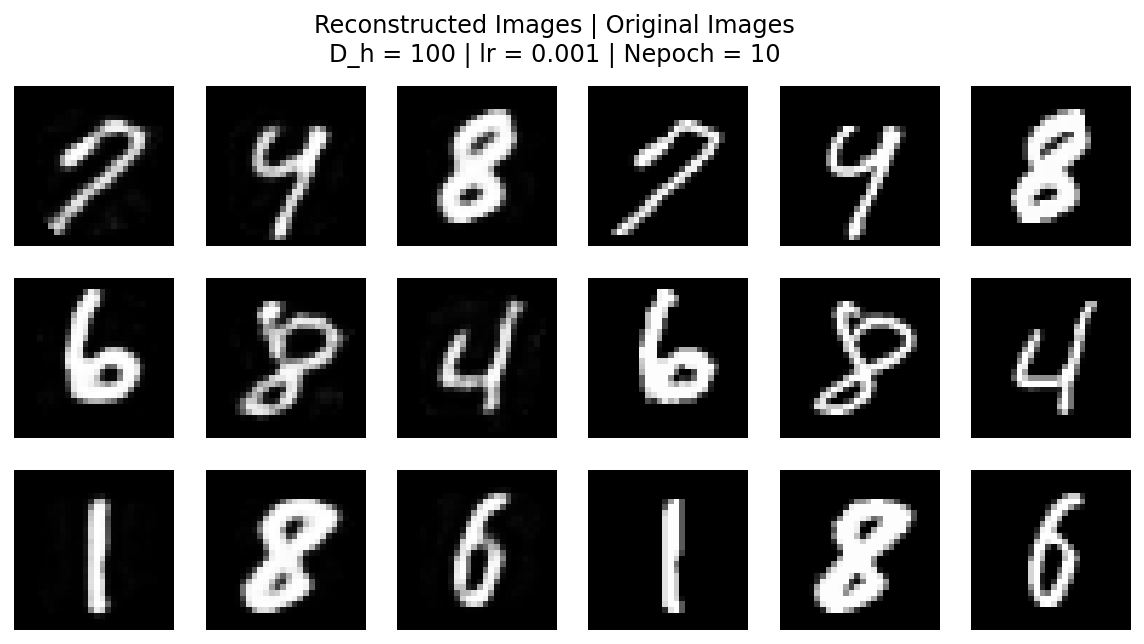

In [ ]:
# Model dimensions
D_in = 784

# Hyperparameters
lr = [0.01, 0.001, 0.001, 0.001]
Nepoch = [15, 15, 10, 10]
D_h = [2, 10, 50, 100]

# Optimizer and learning rate
for i in range(4):
  AE = SimpleAE(D_in, D_h[i])
  optimizer = th.optim.Adam(AE.parameters(), lr=lr[i])
  loss_hist_train, loss_hist_cv, time_trainig = train(AE, optimizer, AE.loss_fn, Xtrain, Xvalid, epochs=Nepoch[i])

  # AE output
  out = AE.forward(Xtrain)

  # Comparison plot
  im_title = 'Reconstructed Images | Original Images' + '\n' + 'D_h = {Dh} | lr = {lr} | Nepoch = {N}'.format(lr = lr[i], Dh = D_h[i], N = Nepoch[i])
  plot_comparison(3, 3, out.detach().numpy(), Xtrain.detach().numpy(), figsz=(10,5), title = im_title )

---
> *As we can see, as the size of the latent space increases, the decoder works better in order to reconstruct the image*

> *That's natural, because the encoder stores the information in a larger space, so the decoder have more data to learn*
---

Time training: 11.27 s
Time training: 12.68 s
Time training: 13.94 s
Time training: 20.65 s


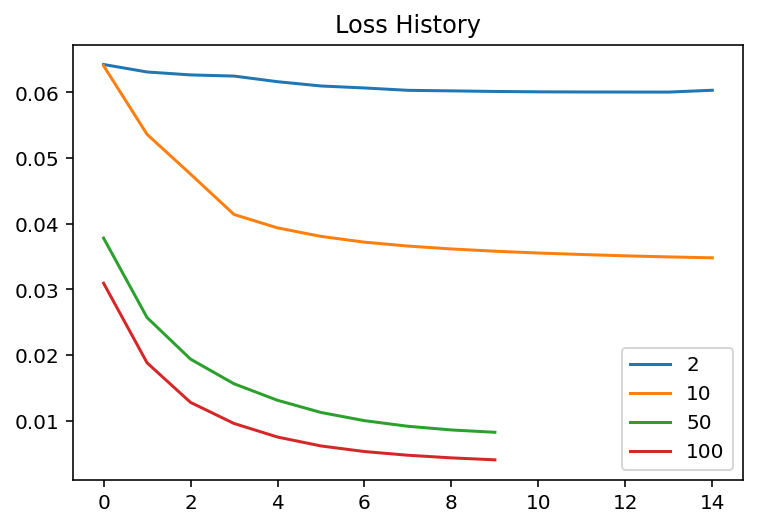

In [ ]:
# Model dimensions
D_in = 784

# Hyperparameters
lr = [0.01, 0.001, 0.001, 0.001]
Nepoch = [15, 15, 10, 10]
D_h = [2, 10, 50, 100]

# Optimizer and learning rate
for i in range(4):
  AE = SimpleAE(D_in, D_h[i])
  optimizer = th.optim.Adam(AE.parameters(), lr=lr[i])
  loss_hist_train, loss_hist_cv, time_trainig = train(AE, optimizer, AE.loss_fn, Xtrain, Xvalid, epochs=Nepoch[i])
  print('Time training: %.2f s' %time_trainig)
  plt.plot(loss_hist_cv, label=str(D_h[i])) # Loss plot (cv)

plt.title('Loss History') # Title and axis title
plt.xlabel = 'Epoch'
plt.ylabel = 'Loss'
plt.legend()
plt.show()

---
> *To have a slightly more quantitative view, we plotted the loss history while varying the latent space.*

> *We observe that the most the latent space is broad, the most the model is optimized*
---

# Anomaly detection
---

> Autoencoders can learn to represent the data in a latent representation space and to reconstruct the data from this compressed representation. One possible application of AE is Anomaly detection. The method is simple: 
- if you encode and decode an image similar to the training data, the reconstruction loss should be low, while 
- if you do the same with an image that differs from the training set, the loss should be higher. 



## Easy case 
> As a preliminary experiment, we can compute the following histograms:  
- the loss on the training data 
- the loss on the training where the images are transposed. 


> **TODO**: code a function that: 
- compute these two histograms
- plots these two histograms on the same figure (plt.hist is your friend)


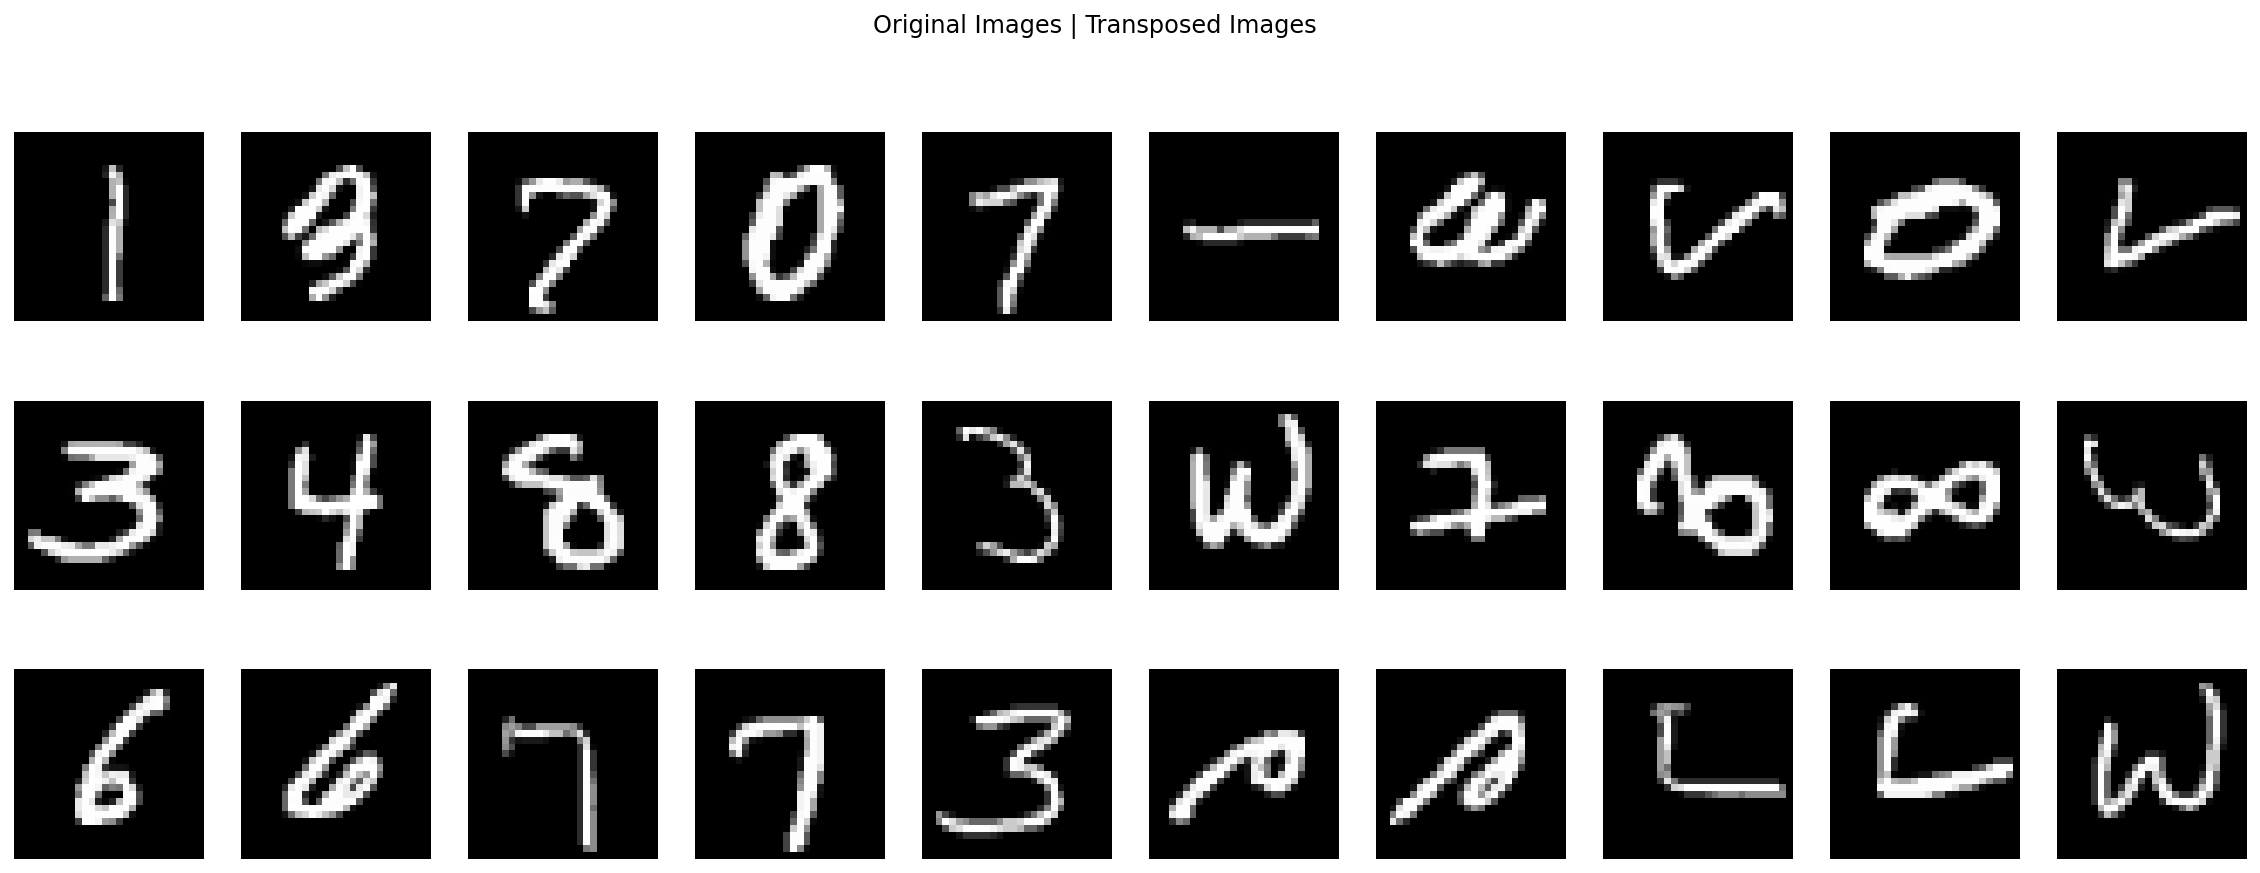

In [ ]:
# Transposing Xtrain
Xtrain_t = transpose_dataset(Xtrain)
plot_comparison(3, 5, Xtrain.detach().numpy(), Xtrain_t.detach().numpy(), figsz=(20,7), title = 'Original Images | Transposed Images')

---
> *The transposition adds symbols that the network doesn't know, for example the 8 looks like infinity, the 3 may look like ω, and so on*

> *This way, we expect to see more anomalies in this dataset compared with the one where the network was trained (a different shape on the histogram)*
---

In [ ]:
def histograms(AE, X, Y): 
  loss_histogram = np.empty((X.shape[0], 1), dtype=np.float32)
  loss_histogram_t = np.empty((Y.shape[0], 1), dtype=np.float32)

  out = AE.forward(X) # Decoded images of X
  for i in range(X.shape[0]):
    loss_histogram[i] = AE.loss_fn(out[i], X[i]).detach().numpy() # loss of each image

  out = AE.forward(Y) # Decoded images of Y
  for i in range(Y.shape[0]):
    loss_histogram_t[i] = AE.loss_fn(out[i], Y[i]).detach().numpy() # loss of each image

  return loss_histogram, loss_histogram_t

> **TODO**: Compare these results when $h$ increases (like before from 2 to 50 and even 100). 

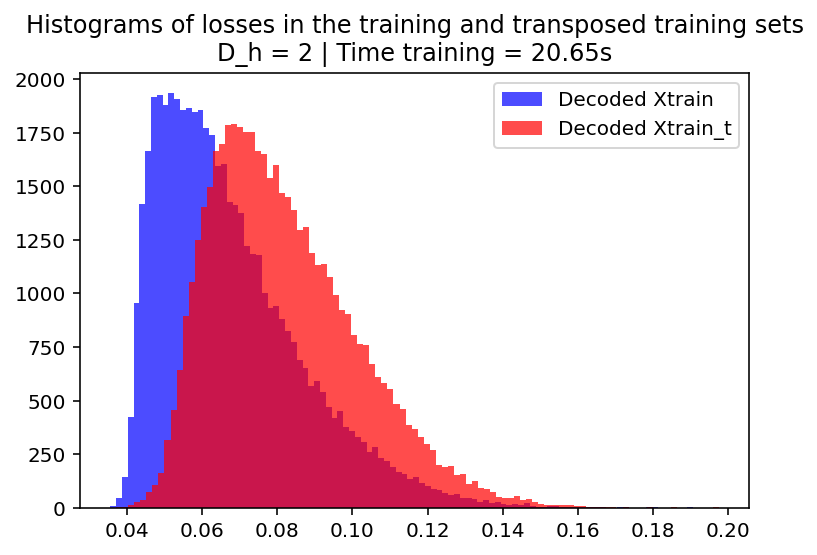

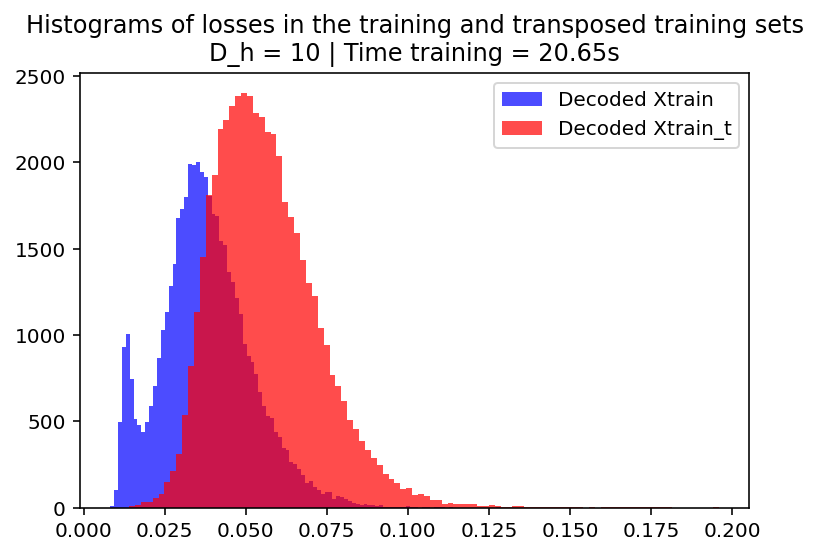

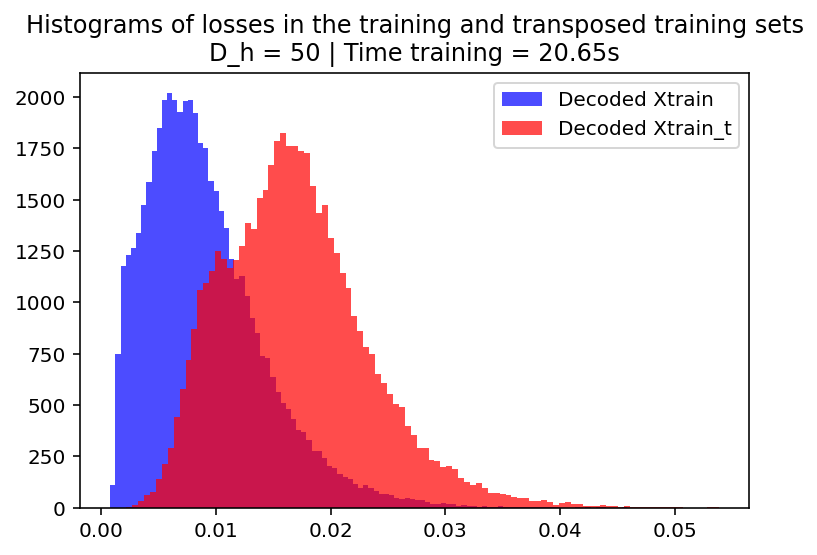

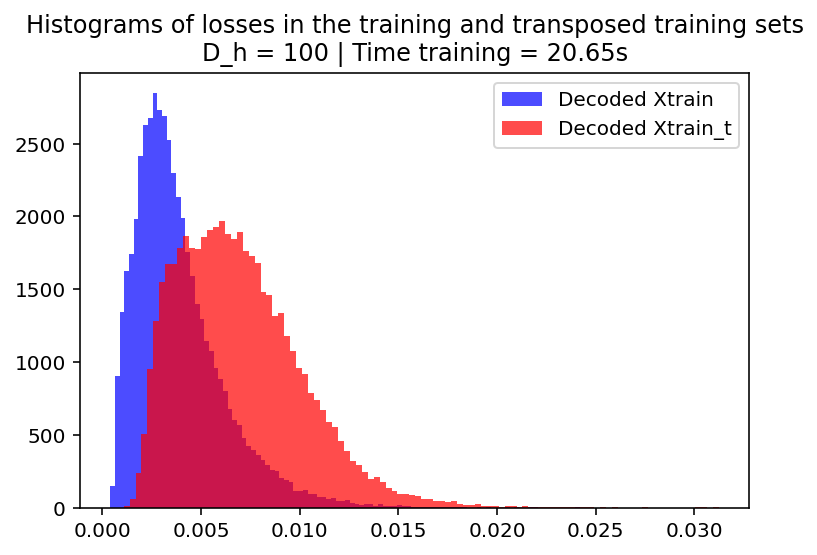

In [ ]:
# Model dimensions
D_in = 784

# Hyperparameters
lr = [0.01, 0.001, 0.001, 0.001]
Nepoch = [15, 15, 10, 10]
D_h = [2, 10, 50, 100]

# Loop in the models (latent space size)
for i in range(len(D_h)):
  AE = SimpleAE(D_in, D_h[i])
  optimizer = th.optim.Adam(AE.parameters(), lr=lr[i])
  train(AE, optimizer, AE.loss_fn, Xtrain, Xvalid, epochs=Nepoch[i])
  loss_hist, loss_hist_t = histograms(AE, Xtrain, Xtrain_t)
  
  # Plots
  plt.hist(loss_hist, bins=100, label='Decoded Xtrain', alpha = 0.7, color='b')
  plt.hist(loss_hist_t, bins=100, label='Decoded Xtrain_t', alpha = 0.7, color='r')
  plt.legend()
  im_title = 'Histograms of losses in the training and transposed training sets' + '\n' + 'D_h = {Dh} | Time training = {tt:.2f}s'.format(Dh = D_h[i], tt = time_trainig)
  plt.title(im_title)
  plt.show()

---
> *For all sizes of latent spacess, we see that the loss on the transposed data have its center displaced at right.*

> *This configure a case where the dataset presents a lot of images that our model doesn't know, so they are anomalies*

> *The more the loss of a single image is far from the center of the $Xtrain$ histogram, the more this image is likely to be considered an anomaly*
---

> **TODO**: 
Compare the histograms of the reconstruction loss of 
- The train
- The validation

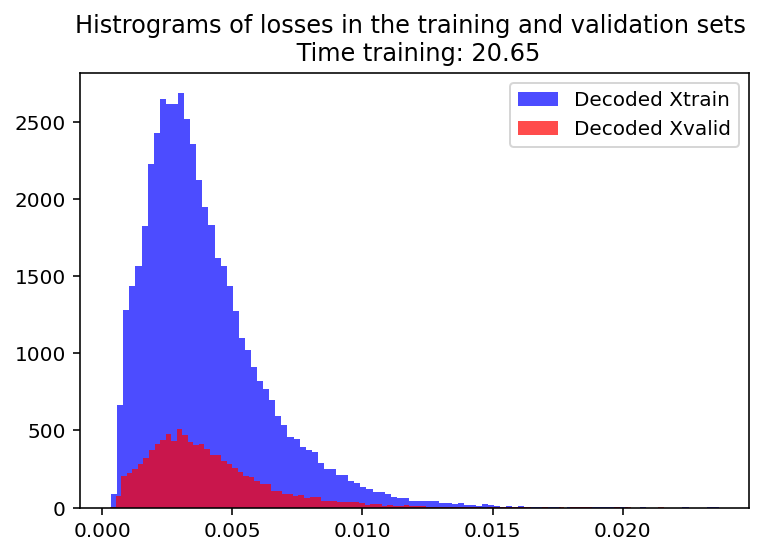

In [ ]:
# Model dimensions
D_in = 784
D_h = 100

# Hyperparameters
lr = 0.001
Nepoch = 10

# Model, optimizer and trainer
AE = SimpleAE(D_in, D_h)
optimizer = th.optim.Adam(AE.parameters(), lr=lr)
train(AE, optimizer, AE.loss_fn, Xtrain, Xvalid, epochs=Nepoch)

# Plots
loss_hist, loss_hist_t = histograms(AE, Xtrain, Xvalid)
plt.hist(loss_hist, bins=100, label='Decoded Xtrain', alpha = 0.7, color='b')
plt.hist(loss_hist_t, bins=100, label='Decoded Xvalid', alpha = 0.7, color='r')
plt.legend()
plt.title('Histrograms of losses in the training and validation sets \n Time training: {tt:.2f}'.format(tt = time_trainig))
plt.show()

---
> *This result shows something alredy expected: the validset is representative of the trainset*

> *This is verified by seeing that both of them presents almost the same distribution, except for the quantity of data*
---

# Semi supervised Training
---


> In semi-supervised training, we will split the training set in two parts: 

In [ ]:
supervised_part = 5000
XunsupTrain = Xtrain # To train the auto-encoder
XsupTrain = Xtrain[:supervised_part] # To train the classifier

> The first idea is to fold: 
- Representation learning:  first learn the AE on its training part *XunsupTrain*. Take for instance an efficient setup (like $h=50$, a good learning rate and number of epochs).   
- Use now the encoder to transform the training data of the classifier *XsupTrain* and train a classifier on these transformed data like in the  first lab session (a classifier with one hidden layer). 

In [ ]:
# Model dimensions
D_in = 784
D_h = 64

# Model and optimization
AE = SimpleAE(D_in, D_h)
optimizer = th.optim.Adam(AE.parameters(), lr=0.001)
_, _, tt = train(AE, optimizer, AE.loss_fn, XunsupTrain, Xvalid, epochs=10) # Training with unsupervised part
print('Time training: {tt:.2f}s'.format(tt=tt))

Time training: 14.55s


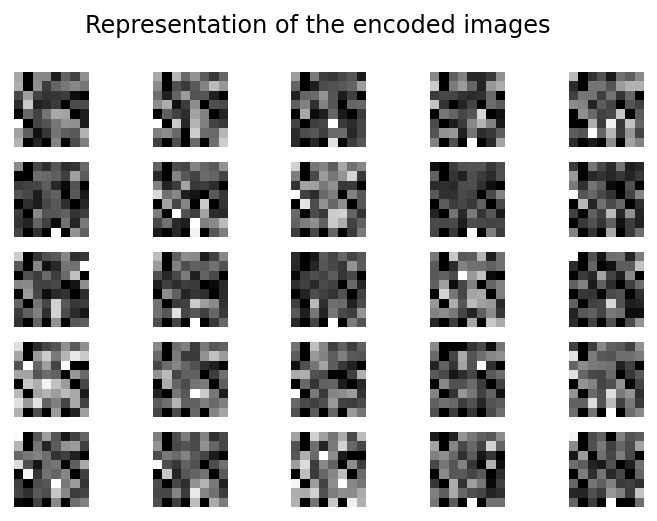

In [ ]:
encoded_imgs = AE.encoder(XsupTrain)
plot_grid(5, 5, encoded_imgs.detach().numpy(), img_dim=(8,8), title = 'Representation of the encoded images')

---
> *We took h=64 to be able to plot the encoded images*
---

In [ ]:
# Function developed on TP1 (classification)

def train_classifier(model, optimizer, loss_fn, Xtrain, Ytrain, Xvalid, Yvalid, epochs=30, minibatch=200, verbose=False):
  # The verbose allows you to skip printed information per epoch.
  # The function will only print the best accuracy on the validation
  # and plot the learning curves.

  ### Mini-batching and shuffle 
  Ntrain = Xtrain.shape[0] 
  Nvalid = Xvalid.shape[0]
  idx = np.arange(Ntrain) # Generate the indices 
  nbatch = int(Ntrain/minibatch) # Number of batches
  np.random.shuffle(idx) # Random order of indices 

  # Lists for learning curves
  loss_hist_train = list()
  loss_hist_cv = list()
  accuracy_hist = list()

  tac = time()
  for n in range(epochs):
    for bi in range(nbatch):
      ids = idx[bi*minibatch:(bi+1)*minibatch] # Get indices of minibatch bi
      images = Xtrain[ids]  # Get the images
      labels = Ytrain[ids]  # The Labels
      optimizer.zero_grad()
      logprobs = model(images) # Inference 
      loss=loss_fn(logprobs,labels) # Compute the loss
      loss.backward(retain_graph=True) # Back Propagation
      optimizer.step() # Update the parameters
    
    # Train loss
    logprobs_train=model(Xtrain) # Inference of the epoch (train)
    loss_train=loss_fn(logprobs_train,Ytrain) # Compute the loss of the epoch (train)
    loss_hist_train.append(loss_train.item())

    # Validation
    with th.no_grad(): # No need to compute the gradient
      model.eval() # Activating the evaluation mode of the model
      logprobs_cv = model(Xvalid) # Inference of the epoch (cv)
      loss_cv=loss_fn(logprobs_cv,Yvalid) # Compute the loss of the epoch (cv)
      loss_hist_cv.append(loss_cv.item())

      # Accuracy
      prob_predict, class_predict = logprobs_cv.topk(1) # Picking the greatest probability (cv)
      accuracy = (class_predict.T == Yvalid).sum().float() / Nvalid # Comparing with the labels
      accuracy_hist.append(accuracy)
    
    model.train() # Returning to training mode
    tic = time()

    if verbose:
      print('Train loss:', loss_train.item(), '\tCV loss:', loss_cv.item())

    time_trainig = tic - tac

  return loss_hist_train, loss_hist_cv, accuracy_hist, time_trainig

> Try different value of *supervised_part* : 100, 500, 1000, 2000, 5000, 10000, ... The criterion of evaluation is the accuracy of the classfier on the validation set.

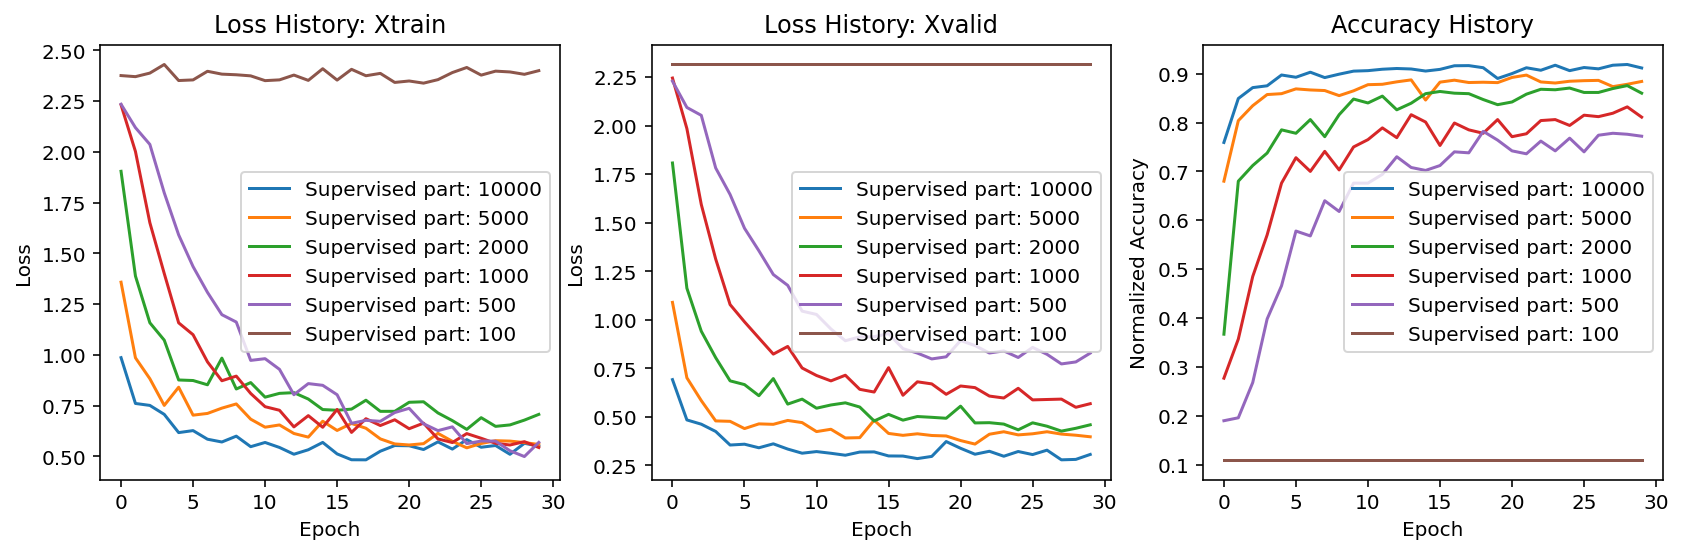

In [ ]:
# supervised_part = [100, 500, 1000, 2000, 5000, 10000]
supervised_part = [10000, 5000, 2000, 1000, 500, 100]

fig, axs = plt.subplots(1, 3, figsize=(14,4)) # For plotting

loss_fn_classifier = nn.NLLLoss() # Loss function of the classifier

for sp in supervised_part:
  XsupTrain = Xtrain[:sp] # To train the classifier
  YsupTrain = Ytrain[:sp]
  XsupValid = Xvalid[:sp]
  YsupValid = Yvalid[:sp]

  # The best classifier of TP1
  classifier = nn.Sequential(
      nn.Linear(64,100),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(100, 50),
      nn.ReLU(),
      nn.Linear(50, 50),
      nn.ReLU(),
      nn.Linear(50, 10),
      nn.LogSoftmax(dim=1)
      )
  
  # Optimizer of the classifier
  opt_classifier = th.optim.Adam(classifier.parameters(),lr=0.01)

  # Encoding images
  encoded_train = AE.encoder(XsupTrain)
  encoded_valid = AE.encoder(XsupValid)

  # Training the classifier
  lht, lhcv, acc, tt = train_classifier(classifier, opt_classifier, loss_fn_classifier, encoded_train, YsupTrain, encoded_valid, YsupValid)

  # Plots
  axs[0].plot(lht, label=('Supervised part: ' + str(sp)))
  axs[1].plot(lhcv, label=('Supervised part: ' + str(sp)))
  axs[2].plot(acc, label=('Supervised part: ' + str(sp)))

axs[0].set_title('Loss History: Xtrain') # Title and axis title
axs[0].set(xlabel = 'Epoch')
axs[0].set(ylabel = 'Loss')
axs[0].legend()

axs[1].set_title('Loss History: Xvalid')
axs[1].set(xlabel = 'Epoch')
axs[1].set(ylabel = 'Loss')
axs[1].legend()

axs[2].set_title('Accuracy History')
axs[2].set(xlabel = 'Epoch')
axs[2].set(ylabel = 'Normalized Accuracy')
axs[2].legend()

plt.show()

---
> *We can see that as we increase the supervised part, the classifier increases its performance*

> *That's reasonable, because the classifier have more data to learn and so it can generalize better the outputs*

> *It's important to note that we don't have an overfitting problem*
---